declustering 

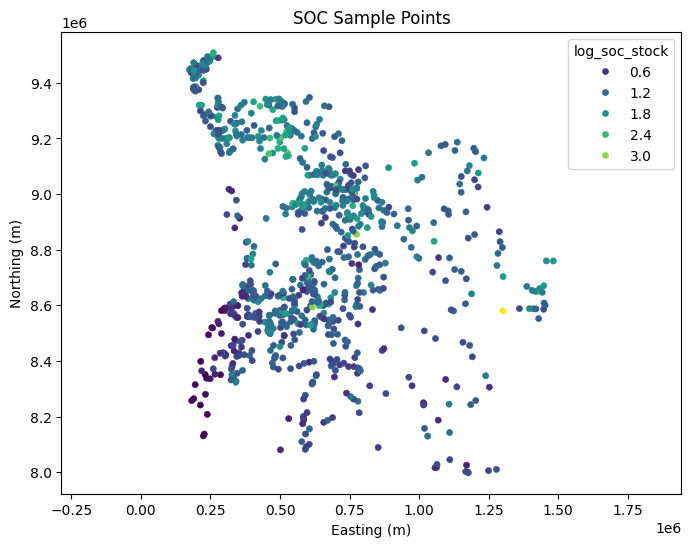

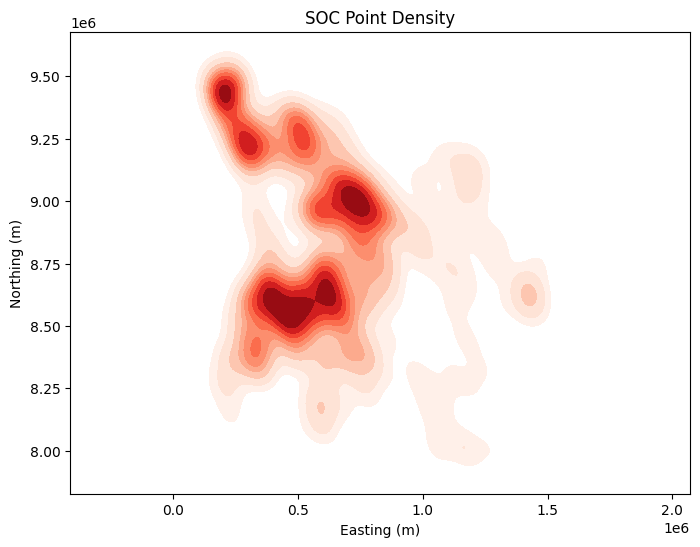

In [1]:
# Visualize cluster densities

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_clean = pd.read_csv("/Users/inesschwartz/Desktop/final_training_dataset.csv")

# Scatter plot of SOC points
plt.figure(figsize=(8,6))
sns.scatterplot(x='X_coord', y='Y_coord', hue='log_soc_stock', data=df_clean,
                palette='viridis', edgecolor=None, s=20)
plt.title('SOC Sample Points')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.show()

# Optional: 2D density plot to highlight clusters
plt.figure(figsize=(8,6))
sns.kdeplot(x='X_coord', y='Y_coord', data=df_clean, fill=True, cmap='Reds', bw_adjust=0.5)
plt.title('SOC Point Density')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.axis('equal')
plt.show()


In [2]:
# quantify clustering

import numpy as np
from scipy.spatial import distance_matrix

coords = df_clean[['X_coord','Y_coord']].values
dist_mat = distance_matrix(coords, coords)

# Compute minimum distance to nearest neighbor for each point (excluding self)
np.fill_diagonal(dist_mat, np.nan)
nearest_dist = np.nanmin(dist_mat, axis=1)

df_clean['nearest_dist'] = nearest_dist
print("Nearest neighbor distance summary:")
print(pd.Series(nearest_dist).describe())


Nearest neighbor distance summary:
count       890.000000
mean      13707.995697
std       13254.378813
min         202.505747
25%        4873.545652
50%        9843.602880
75%       17794.570518
max      142212.564236
dtype: float64


In [3]:
print(df_clean.X_coord.min(), df_clean.X_coord.max())
print(df_clean.Y_coord.min(), df_clean.Y_coord.max())


174544.60741365992 1482544.1461838111
7998325.191518262 9508186.763478452


In [4]:
import libpysal
from esda.moran import Moran

# Build spatial weights (inverse distance or KNN)
w = libpysal.weights.DistanceBand(coords, threshold=10000, binary=False, alpha=-1)  # 10 km threshold

# Moran's I for SOC
soc = df_clean['log_soc_stock'].values
mi = Moran(soc, w)
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")


('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNI

/opt/homebrew/lib/python3.11/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/opt/homebrew/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 579 disconnected components.
 There are 439 islands with ids: 1, 2, 3, 4, 5, 7, 8, 10, 14, 16, 17, 18, 19, 20, 24, 25, 28, 30, 31, 33, 34, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 66, 70, 79, 84, 107, 109, 115, 123, 132, 136, 147, 151, 157, 164, 165, 166, 168, 169, 171, 172, 173, 175, 182, 183, 184, 185, 186, 187, 188, 195, 202, 203, 205, 229, 239, 244, 245, 246, 247, 248, 252, 255, 256, 259, 260, 261, 262, 263, 265, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 286, 289, 290, 291, 292, 293, 298, 299, 300, 301, 302, 303, 304, 305, 308, 312, 313, 314, 316, 319, 322, 323, 325, 326, 328, 329, 331, 333, 334, 335, 336, 34

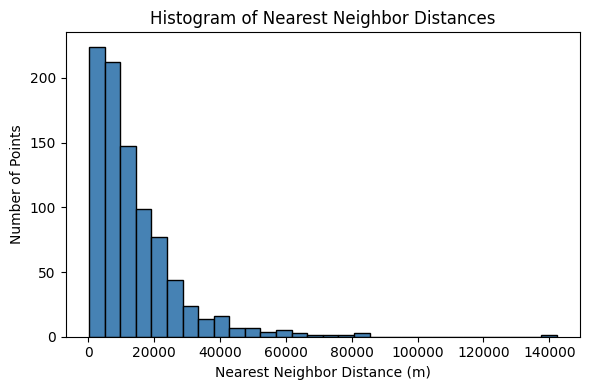

In [5]:
# histogram nearest_dist

import matplotlib.pyplot as plt

# Assuming 'nearest_dist' column already exists
plt.figure(figsize=(6,4))
plt.hist(df_clean['nearest_dist'], bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Nearest Neighbor Distance (m)')
plt.ylabel('Number of Points')
plt.title('Histogram of Nearest Neighbor Distances')
plt.tight_layout()
plt.show()


In [6]:
# Correct cluster bias (declustering / weighting)
# general idea: points in dense clusters get smaller weights; isolated points get larger weights.


from sklearn.neighbors import KDTree

coords = df_clean[['X_coord','Y_coord']].values
tree = KDTree(coords)

# Count neighbors within a threshold distance (e.g., 10 km)
threshold = 5000  # adjust based on your study area
neighbors_count = tree.query_radius(coords, r=threshold, count_only=True)

# Compute weights: inverse of local density
df_clean['weight'] = 1 / neighbors_count
df_clean['weight'] = df_clean['weight'] / df_clean['weight'].mean()  # normalize to mean=1

print(df_clean[['nearest_dist','weight']].head())


   nearest_dist    weight
0   3189.086387  0.583734
1  32417.821083  1.167468
2  17447.713671  1.167468
3  17664.992628  1.167468
4  17807.125956  1.167468


### computing kernel densities to get "sample_weight"

In [7]:
from sklearn.neighbors import KernelDensity

# Fit KDE (bandwidth in meters)
kde = KernelDensity(bandwidth=5000, kernel='gaussian')
kde.fit(coords)

log_density = kde.score_samples(coords)
density = np.exp(log_density)

# Compute declustering weight
df_clean['sample_weight'] = 1 / density
df_clean['sample_weight'] /= df_clean['sample_weight'].mean()  # normalize to mean=1


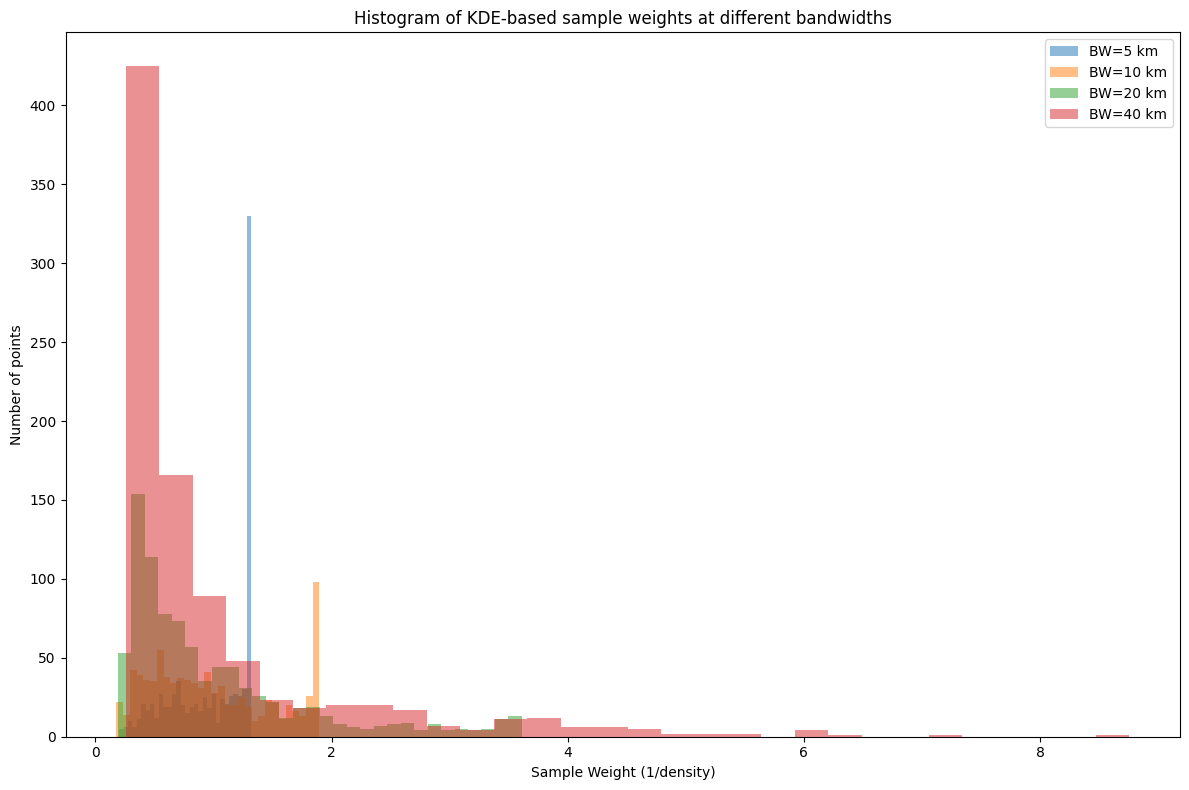

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Coordinates array
coords = df_clean[['X_coord', 'Y_coord']].values

# Bandwidths to test (in meters, adjust according to your study area)
bandwidths = [5000, 10000, 20000, 40000]  # 5 km, 10 km, 20 km, 40 km

plt.figure(figsize=(12,8))

for bw in bandwidths:
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(coords)
    
    log_density = kde.score_samples(coords)
    density = np.exp(log_density)
    sample_weight = 1 / density
    sample_weight /= sample_weight.mean()  # normalize to mean = 1
    
    # Plot histogram
    plt.hist(sample_weight, bins=30, alpha=0.5, label=f'BW={bw/1000:.0f} km')

plt.xlabel('Sample Weight (1/density)')
plt.ylabel('Number of points')
plt.title('Histogram of KDE-based sample weights at different bandwidths')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
from scipy.spatial import cKDTree

coords = df_clean[['X_coord', 'Y_coord']].values

def weighted_nn_stats(coords, weights):
    tree = cKDTree(coords)
    dists, idx = tree.query(coords, k=2)  # k=2: first nearest neighbor excluding itself
    nn_dist = dists[:,1]
    return np.mean(nn_dist / weights), np.std(nn_dist / weights)

# Example
print(weighted_nn_stats(coords, df_clean['sample_weight'].values))


(12043.407451324592, 9141.96031051005)


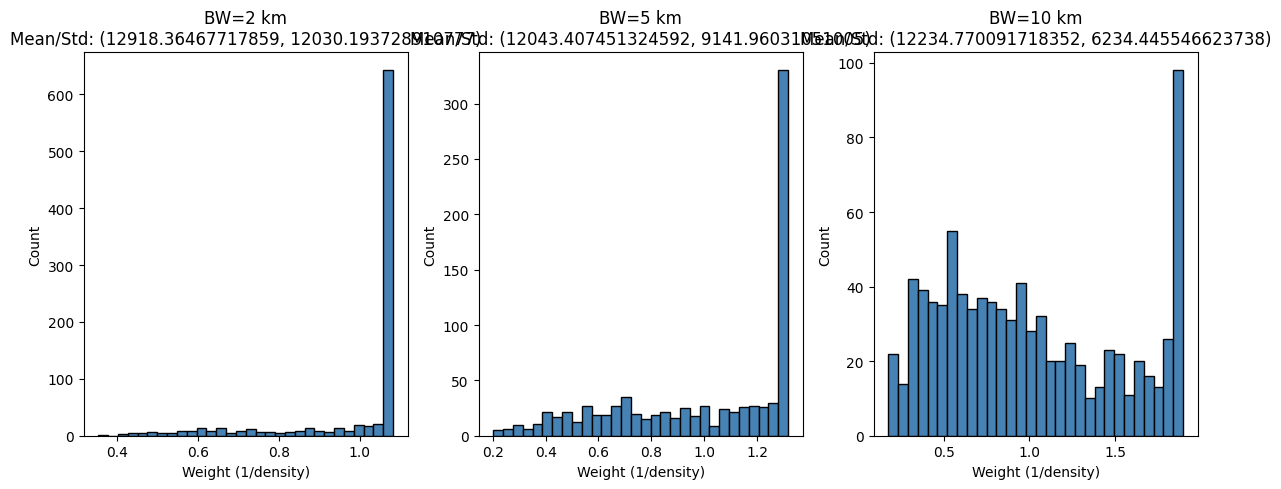

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.spatial import cKDTree

coords = df_clean[['X_coord', 'Y_coord']].values
bandwidths = [2000, 5000, 10000]  # 2 km, 5 km, 10 km

def weighted_nn_stats(coords, weights):
    tree = cKDTree(coords)
    dists, idx = tree.query(coords, k=2)  # nearest neighbor excluding self
    nn_dist = dists[:,1]
    return np.mean(nn_dist / weights), np.std(nn_dist / weights)

plt.figure(figsize=(12, 5))
for i, bw in enumerate(bandwidths):
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(coords)
    
    log_density = kde.score_samples(coords)
    density = np.exp(log_density)
    sample_weight = 1 / density
    sample_weight /= sample_weight.mean()  # normalize to mean=1
    
    # Histogram of weights
    plt.subplot(1, len(bandwidths), i+1)
    plt.hist(sample_weight, bins=30, color='steelblue', edgecolor='black')
    plt.xlabel('Weight (1/density)')
    plt.ylabel('Count')
    plt.title(f'BW={bw/1000:.0f} km\nMean/Std: {weighted_nn_stats(coords, sample_weight)}')
plt.tight_layout()
plt.show()


In [11]:
df_clean.columns

Index(['X_coord', 'Y_coord', 'site_info_id', 'profile', 'district',
       'landsurface_value', 'litho_value', 'formation', 'annual_mean_temp',
       'annual_precip', 'isothermality', 'precip_driest_month',
       'precip_seasonality', 'precip_wettest_month', 'temp_annual_range',
       'temp_seasonality', 'MRVBF', 'RLD', 'aspect', 'aspect_cos',
       'aspect_sin', 'DEM', 'flow_accumulation', 'relief', 'slope', 'TWI',
       'valleydepth', 'faosoil_id', 'log_soc_stock', 'nearest_dist', 'weight',
       'sample_weight'],
      dtype='object')

Spatial cross validation:


Block size: 20000 m
Points per block (min, median, max): 1, 1.0, 10
Total unique blocks: 601

Block size: 50000 m
Points per block (min, median, max): 1, 2.0, 23
Total unique blocks: 294

Block size: 100000 m
Points per block (min, median, max): 1, 4.0, 42
Total unique blocks: 124

Block size: 50000 m
Points per block (min, median, max): 1, 2.0, 23
Total unique blocks: 294


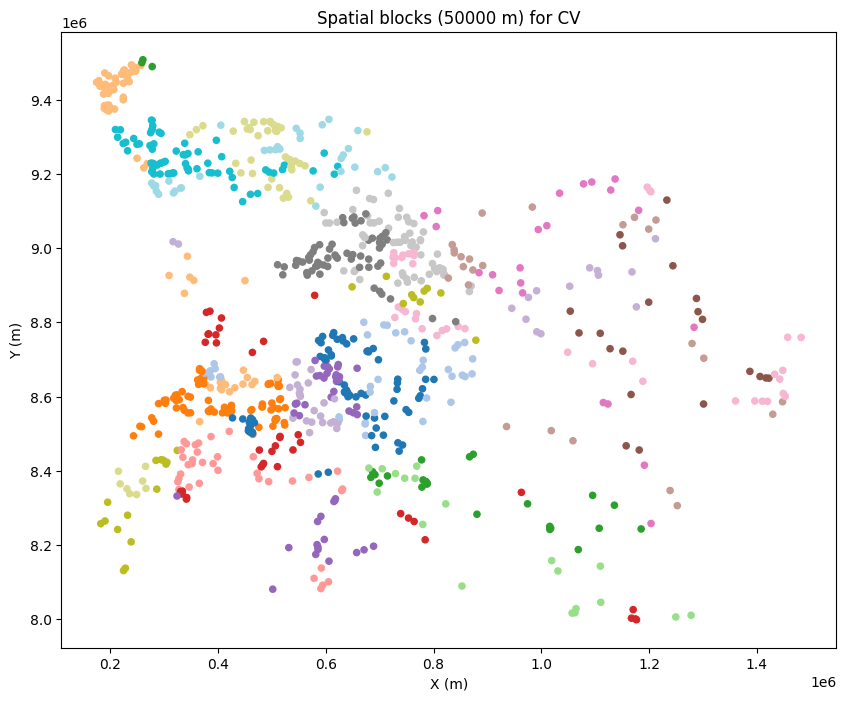

Fold 1: Train=712 Test=178
Fold 2: Train=712 Test=178
Fold 3: Train=712 Test=178
Fold 4: Train=712 Test=178
Fold 5: Train=712 Test=178


In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Load your SOC points (coords already in meters)
# -----------------------------
gdf = gpd.GeoDataFrame(df_clean, 
                       geometry=gpd.points_from_xy(df_clean.X_coord, df_clean.Y_coord),
                       crs="EPSG:32733")

# -----------------------------
# 2️⃣ Function to create and summarize blocks
# -----------------------------
def create_blocks(gdf, block_size):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Make sure bins cover full extent
    x_bins = np.arange(xmin, xmax + block_size, block_size)
    y_bins = np.arange(ymin, ymax + block_size, block_size)

    # assign each point to a bin (subtract 1 to start indices at 0)
    gdf['block_x'] = np.digitize(gdf['X_coord'], x_bins) - 1
    gdf['block_y'] = np.digitize(gdf['Y_coord'], y_bins) - 1
    gdf['block_id'] = gdf['block_x'].astype(str) + "_" + gdf['block_y'].astype(str)

    counts = gdf.groupby('block_id').size()
    print(f"\nBlock size: {block_size} m")
    print(f"Points per block (min, median, max): {counts.min()}, {counts.median()}, {counts.max()}")
    print(f"Total unique blocks: {counts.shape[0]}")

    return gdf, counts

# -----------------------------
# 3️⃣ Try different block sizes
# -----------------------------
block_sizes = [20000, 50000, 100000]  # meters
for bs in block_sizes:
    gdf_test, counts = create_blocks(gdf, bs)

# -----------------------------
# 4️⃣ Choose final block size
# -----------------------------
final_block_size = 50000
gdf, counts = create_blocks(gdf, final_block_size)

# -----------------------------
# 5️⃣ Visualize blocks
# -----------------------------
plt.figure(figsize=(10,8))
# color by unique block id
block_ids = pd.factorize(gdf['block_id'])[0]
plt.scatter(gdf.X_coord, gdf.Y_coord, c=block_ids, cmap='tab20', s=20)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f'Spatial blocks ({final_block_size} m) for CV')
plt.show()

# -----------------------------
# 6️⃣ GroupKFold using block_id
# -----------------------------
n_folds = 5
gkf = GroupKFold(n_splits=n_folds)

X = gdf.drop(columns=['log_soc_stock', 'geometry', 'block_id'])
y = gdf['log_soc_stock']
groups = gdf['block_id']

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"Fold {fold+1}: Train={len(train_idx)} Test={len(test_idx)}")


In [13]:

print(gdf.X_coord.min(), gdf.X_coord.max())
print(gdf.Y_coord.min(), gdf.Y_coord.max())


174544.60741365992 1482544.1461838111
7998325.191518262 9508186.763478452


In [14]:
print("X min/max:", gdf['X_coord'].min(), gdf['X_coord'].max())
print("Y min/max:", gdf['Y_coord'].min(), gdf['Y_coord'].max())
print("gdf.total_bounds:", gdf.total_bounds)


X min/max: 174544.60741365992 1482544.1461838111
Y min/max: 7998325.191518262 9508186.763478452
gdf.total_bounds: [ 174544.60741366 7998325.19151826 1482544.14618381 9508186.76347845]
